In [2]:
from fco2models.models import UNet2DModelWrapper, Unet2DClassifierFreeModel
from fco2models.ueval import load_models
model_info = {
    'cfree_100': ['../models/newds/', 'e_200.pt', UNet2DModelWrapper ]#lambda **model_params: Unet2DClassifierFreeModel(model_params, keep_channels=[0, 1, 2, 13], num_channels=14)],
}
models = load_models(model_info)

In [3]:
# compute these values for all models
from fco2models.ueval import print_loss_info
for key in models.keys():
    print(f'loading {key}')
    print_loss_info(models[key])

loading cfree_100
min epoch: 193
min train loss: 0.014460048354594765
min val loss epoch: 178
min val loss: 0.05858154521946218
----------------------------------


In [ ]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df, make_monthly_split, get_segments_random, get_segments, get_context_mask, normalize_dss, get_stats_df
DATA_PATH = "../data/training_data/"
df = pd.read_parquet(DATA_PATH + "SOCAT_1982_2021_grouped_colloc_augm_bin.pq", engine='pyarrow')
df = prep_df(df, bound=True, add_clim=False, add_seas=False)[0]
# df['sst_clim'] += 273.15
# df['sst_anom'] = df['sst_cci'] - df['sst_clim']
# df['sss_anom'] = df['sss_cci'] - df['sss_clim']
# df['chl_anom'] = df['chl_globcolour'] - df['chl_clim']
# df['ssh_anom'] = df['ssh_sla'] - df['ssh_clim']
# df['mld_anom'] = df['mld_dens_soda'] - df['mld_clim']
#map expocode column to int
expocode_map = df['expocode'].unique()
expocode_map = {expocode: i for i, expocode in enumerate(expocode_map)}
df['expocode_id'] = df['expocode'].map(expocode_map) 
print(df.columns)

2025-06-20 18:54:26,512 - INFO - salinity stacking
2025-06-20 18:54:26,581 - INFO - adding positional and temporal encodings
2025-06-20 18:54:28,592 - INFO - add climatology data
2025-06-20 18:54:50,306 - INFO - adding xco2 data
2025-06-20 18:54:53,125 - INFO - removing xco2 levels from fco2rec_uatm
2025-06-20 18:54:53,152 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


Index(['index', 'expocode', 'window_id', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north',
       'co2_clim8d', 'xco2', 'expocode_id'],
      dtype='object')


In [5]:
expocodes = df['expocode_id'].unique()
print(f"number of unique expocodes: {len(expocodes)}")

number of unique expocodes: 6969


In [6]:
expocode = expocode_map["AG5W20141113"]#expocodes[1000]
print(f'Expocode ID: {expocode}')
cruise = df[df['expocode_id'] == expocode]
print(f'Cruise shape: {cruise.shape}')

Expocode ID: 5725
Cruise shape: (1682, 60)


In [7]:
model_info = models['cfree_100']
predictors = model_info['params']['predictors']
target = 'fco2rec_uatm'
info = 'window_id'
cols = [target] + predictors + [info]
cruise_ds = get_segments(cruise, cols)

In [8]:
predictors

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

In [9]:
from fco2models.utraining import normalize_dss
params = model_info['params']
stats = {
    'means': params['train_means'],
    'stds': params['train_stds'],
    'mins': params['train_mins'],
    'maxs': params['train_maxs'],
}
window_ids = cruise_ds[:, -1:, :].astype(int)
cruise_ds = normalize_dss([cruise_ds[:, :-1, :]], stats, params['mode'])[0]

2025-06-20 18:54:53,699 - INFO - Using given stats for normalization
2025-06-20 18:54:53,700 - INFO - Normalizing data using min_max normalization
2025-06-20 18:54:53,702 - INFO - Not normalizing features: []


In [10]:
from fco2models.utraining import full_denoise
from fco2models.ueval import rescale
import torch
from torch.utils.data import DataLoader
from diffusers import DDIMScheduler

n_rec = 50
context_ds = np.repeat(cruise_ds[:, 1:, :], n_rec, axis=0)
context_ds = torch.from_numpy(context_ds).float()
target_ds = cruise_ds[:, 0, :]

#model_info['model'].set_w(1)
loader = DataLoader(context_ds, batch_size=128, shuffle=False)
scheduler = DDIMScheduler(num_train_timesteps=model_info['noise_scheduler'].config.num_train_timesteps,
                          beta_schedule=model_info['noise_scheduler'].config.beta_schedule,
                          clip_sample_range=model_info['noise_scheduler'].config.clip_sample_range,
                          )
scheduler.set_timesteps(50)
samples_norm = full_denoise(model_info['model'], scheduler, loader, jump=None)
samples = rescale(samples_norm.copy(), params, params['mode'])

Training on cuda


Inference: 100%|██████████| 11/11 [00:32<00:00,  3.00s/it, timestep=tensor(0)]  


In [11]:

def samples_to_df(samples, index):
    samples_index = np.concatenate((samples, index), axis=1)
    # print(samples_index.shape)
    n_samples, n_cols, n_bins = samples_index.shape
    samples_index_flat = np.full((n_samples*n_bins, n_cols), np.nan)
    for i in range(samples_index.shape[1]):
        samples_index_flat[:, i] = samples_index[:, i, :].flatten()
    df = pd.DataFrame(samples_index_flat, columns=[f"sample_{i}" for i in range(n_rec)] + ['window_id'])
    df['window_id'] = df['window_id'].astype(int)
    df.set_index(['window_id'], inplace=True)
    return df

res_df = samples_to_df(samples.reshape(-1, n_rec, 64), window_ids)
pred_columns = res_df.columns[:-1]
res_df['mean_pred'] = res_df[pred_columns].mean(axis=1)
res_df['std_pred'] = res_df[pred_columns].std(axis=1)

cruise.set_index(['window_id'], inplace=True)
cruise = pd.concat([cruise, res_df], axis=1)
cruise.reset_index(inplace=True)

In [12]:
cruise.columns

Index(['window_id', 'index', 'expocode', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss',
       ...
       'sample_42', 'sample_43', 'sample_44', 'sample_45', 'sample_46',
       'sample_47', 'sample_48', 'sample_49', 'mean_pred', 'std_pred'],
      dtype='object', length=112)

In [13]:
from sklearn import metrics

def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')),)
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()
    ax.set_xticks(np.arange(0, int(y.index.max()), 64))
    

def plot_diff_samples(ax, recs, truth, **kwargs):
    windows = recs.index.get_level_values('window_id')
    recs = recs.values.T
    mean_pred = recs.mean(axis=0)
    uncert = recs.std(axis=0)
    ax.plot(windows, truth, **kwargs)
    ax.plot(windows, mean_pred, **kwargs)
    ax.fill_between(windows, mean_pred-uncert, mean_pred+uncert, alpha=0.2, color='k')

def plot_all_samples(ax, recs, truth, **kwargs):
    windows = recs.index.get_level_values('window_id')
    recs = recs.values.T
    ax.plot(windows, truth, **kwargs)
    ax.plot(windows, recs.T, **kwargs, alpha=0.5)


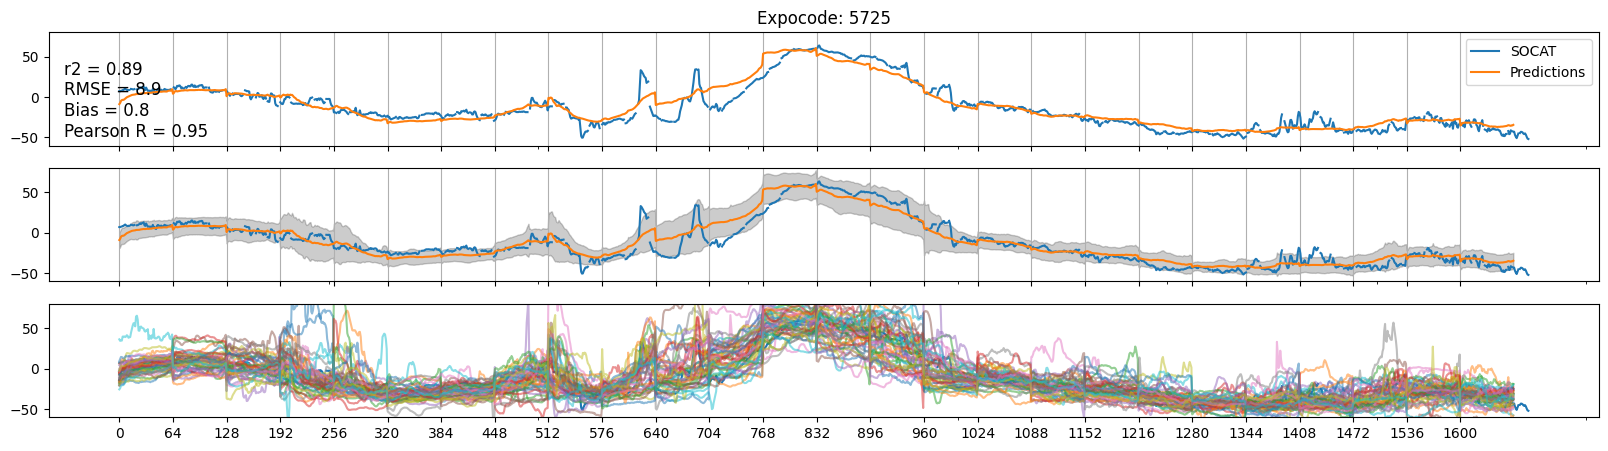

In [14]:
import matplotlib.pyplot as plt
cruise.set_index(['window_id'], inplace=True)
fig, axs = plt.subplots(3, 1, figsize=(20, 5), sharex=True, sharey=True)
plot_line_comparison(axs[0], cruise['fco2rec_uatm'], cruise['mean_pred'], label='Predictions')
axs[0].set_title(f"Expocode: {expocode}")
axs[0].grid(True, axis='x')
axs[0].set_ylim(-60, 80)
plot_diff_samples(axs[1],cruise[pred_columns], cruise['fco2rec_uatm'], label='Predictions')
axs[1].grid(True, axis='x')
plot_all_samples(axs[2], cruise[pred_columns], cruise['fco2rec_uatm'], label='Predictions')
cruise.reset_index(inplace=True)

with random shifts

In [15]:
cruise.drop(columns=pred_columns, inplace=True)

In [16]:
model_info = models['cfree_100']
params = model_info['params']
predictors = model_info['params']['predictors']
predictors

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

In [17]:
def diffusion_step(model, noise_scheduler, x, t, jump):
    # Get model pred
    sample = x[:, 0:1, :]  # Assuming the first channel is the sample
    with torch.no_grad():
        residual = model(x, t, return_dict=False)[0]
    output_scheduler = noise_scheduler.step(residual, t, sample)
    if jump is not None:
        x_0 = output_scheduler.pred_original_sample
        if t < jump:
            sample = x_0
            # sample = output_scheduler.prev_sample
        else:
            sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample), t - jump)
    else:
        # Update sample with step
        sample = output_scheduler.prev_sample
    return sample

from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from fco2models.ueval import rescale
def multidiffusion_denoise(model, noise_scheduler, sample_context, overlap_fun, jump=20, n_rec=5):
    """full denoising loop for diffusion model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")
    model.to(device)

    sample_shape = (n_rec, sample_context.shape[0])
    sample_context = np.stack([sample_context] * n_rec, axis=0)  # Repeat context for n_rec
    sample_context[:, :, 0] = np.random.randn(*sample_shape)  # Initialize the first channel with random values
    step = 0
    all_samples = [sample_context[:, :, 0].copy()]

    t_loop = noise_scheduler.timesteps[::jump]
    #t_full = torch.arange(jump-1, -1, -1)
    #t_loop = torch.cat([t_loop, t_full], dim=0)  # Concatenate the timesteps for the loop
    print(f"Timesteps for inference: {t_loop}")

    for t in tqdm(t_loop, desc=f"Inference"):
        sample_context_overlap, windows_overlap = overlap_fun(sample_context, step, n_rec=n_rec)
        sample_context_overlap = torch.from_numpy(sample_context_overlap).float().to(device)
        loader = DataLoader(sample_context_overlap, batch_size=128, shuffle=False)
        samples = []
        for batch in loader:
            batch = batch.to(device)
            sample = diffusion_step(model, noise_scheduler, batch, t, jump)
            samples.append(sample.cpu().numpy())

        samples = np.concatenate(samples, axis=0).reshape(n_rec, -1)
        sample = np.zeros(sample_shape, dtype=np.float32)
        weights = np.zeros(sample_shape, dtype=np.float32)


        for rec in range(samples.shape[0]):
            for i in range(samples.shape[1]):
                sample[rec, windows_overlap[rec, i]] += samples[rec, i]
                weights[rec, windows_overlap[rec, i]] += 1
        
        #replace zero weights with nans
        weights[weights == 0] = np.nan
        sample /= weights
        # if (jump is not None) and t - jump > 0:
        sample[np.isnan(sample)] = sample_context[np.isnan(sample), 0]

        sample_context[:, :, 0] = sample  # Update the context with the new sample
        all_samples.append(sample_context[:, :, 0].copy())
        step += 1

    return sample_context, np.array(all_samples)

In [18]:
cruise_array = cruise[predictors].values
window_ids = cruise['window_id'].values
padded_cruise_array = np.pad(cruise_array, ((64, 64), (0, 0)), mode='symmetric')
cruise_array.shape, padded_cruise_array.shape

((1682, 12), (1810, 12))

In [19]:
def shifting_fun(sample_context, step, n_rec, segment_len=64):
    # sample_context is expected to be of shape (n_rec, n_samples, n_features)
    windows = np.arange(sample_context.shape[1])
    ds = []
    ds_windows = []
    for rec in range(n_rec):
        offset = np.random.randint(-20,20)
        # if step>=45:
        #     print(f"Processing record {rec}, offset: {offset}")
        #print(f"Processing record {rec}, offset: {offset}")
        sample_context_rec = sample_context[rec, segment_len + offset:-segment_len + offset:, :]
        windows_rec = windows[segment_len + offset:-segment_len + offset]

        n_segments = sample_context_rec.shape[0] // segment_len # this should be constant anyway but whatever
        n_c = sample_context_rec.shape[1] # this too
        ds_rec = np.zeros((n_segments, n_c, segment_len), dtype=np.float32)
        for c in range(sample_context_rec.shape[1]):
            ds_rec[:, c, :] = sample_context_rec[:n_segments*segment_len, c].reshape(n_segments, segment_len)
        windows_rec = windows_rec[:n_segments*segment_len]
        ds.append(ds_rec)
        ds_windows.append(windows_rec)

    ds = np.concatenate(ds, axis=0)
    ds_windows = np.concatenate(ds_windows, axis=0)
    ds_windows = ds_windows.reshape(n_rec, -1)

    return ds, ds_windows

def md_fun(sample_context, _, n_rec, segment_len=64):
    # sample_context is expected to be of shape (n_rec, n_samples, n_features)
    windows = np.arange(sample_context.shape[1])
    ds = []
    ds_windows = []
    for rec in range(n_rec):
        for step in range(0, sample_context.shape[1] - segment_len + 1, segment_len - 15):
            ds_step = sample_context[rec, step:step + segment_len, :]
            ds.append(ds_step.swapaxes(0, 1)[np.newaxis])  # Swap axes to have (n_rec, n_features, segment_len)
            ds_windows.append(windows[step:step + segment_len])
    ds = np.concatenate(ds, axis=0)
    # ds = ds.swapaxes(1, 2)  
    ds_windows = np.concatenate(ds_windows, axis=0)
    ds_windows = ds_windows.reshape(n_rec, -1)
    # ds_windows = np.tile(win)  # Repeat windows for n_rec
    #print(f"ds shape: {ds.shape}, ds_windows shape: {ds_windows.shape}")

    return ds, ds_windows


In [20]:
from diffusers import DDIMScheduler
sample = np.full((padded_cruise_array.shape[0], 1), np.nan)
#mask = np.ones_like(sample)
sample_context = np.concatenate((sample, padded_cruise_array), axis=1)
stats = {
    'means': params['train_means'],
    'stds': params['train_stds'],
    'mins': params['train_mins'],
    'maxs': params['train_maxs'],
}
sample_context = normalize_dss([sample_context[:, :, np.newaxis]], stats, params['mode'])[0]
#sample_context[:, 0, 0] = np.random.randn(sample_context.shape[0])  # Random noise for the first channel
sample_context = np.concatenate((sample_context, np.ones_like(sample)[:, :, np.newaxis]), axis=1) # Set the last channel to ones

scheduler = DDIMScheduler(num_train_timesteps=model_info['noise_scheduler'].config.num_train_timesteps,
                          beta_schedule=model_info['noise_scheduler'].config.beta_schedule,
                          clip_sample_range=model_info['noise_scheduler'].config.clip_sample_range,
                          )
scheduler.set_timesteps(50)
# model_info['model'].set_w(1)
n_rec = 100
sample, all_samples = multidiffusion_denoise(
    model_info['model'],
    scheduler,
    sample_context.squeeze(axis=-1),
    overlap_fun=shifting_fun,  
    jump=None,
    n_rec=n_rec
)
sample[:, :, 0:1] = rescale(sample[:, :, 0:1].reshape(-1, 1), params, params['mode']).reshape(n_rec, -1, 1)

2025-06-20 18:55:27,653 - INFO - Using given stats for normalization
2025-06-20 18:55:27,654 - INFO - Normalizing data using min_max normalization
2025-06-20 18:55:27,656 - INFO - Not normalizing features: []


Training on cuda
Timesteps for inference: tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])


Inference: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


In [21]:
print(all_samples.shape)

(51, 100, 1810)


In [22]:
params['predictors'] 

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

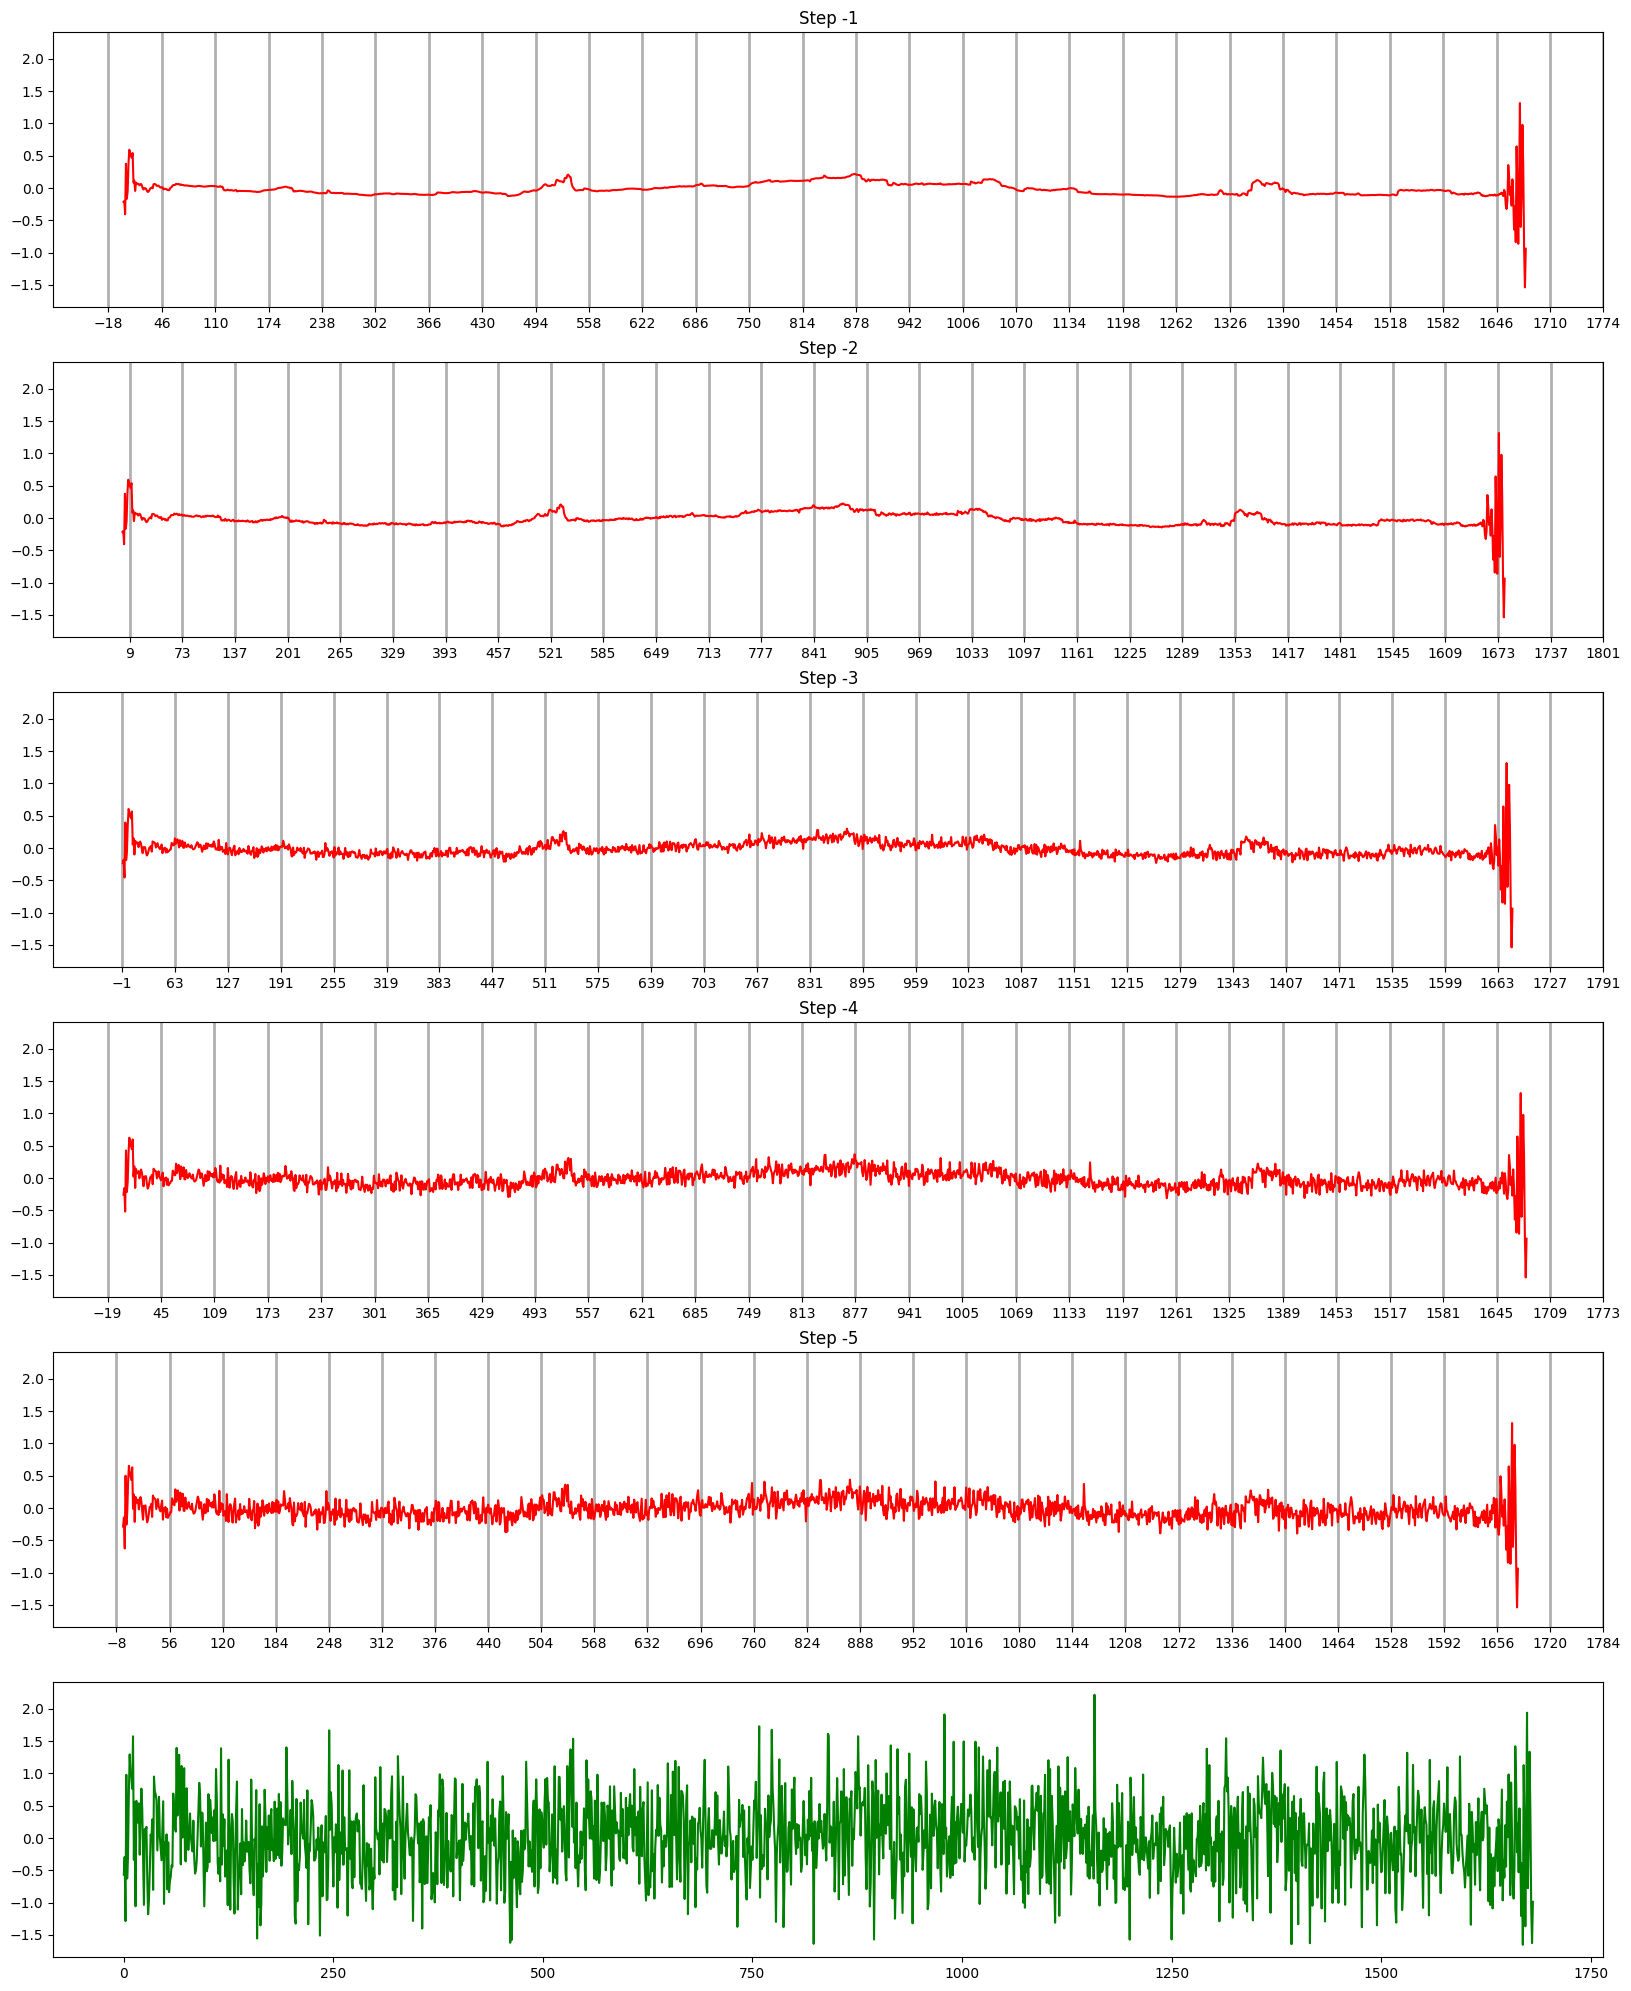

In [23]:
import matplotlib.pyplot as plt
n_steps = 5
fig, ax = plt.subplots(n_steps + 1, 1, figsize=(20, n_steps*5), sharey=True)
offsets = [-18, 9, -1, -19, -8]
for i in range(1, n_steps + 1):
    s = all_samples[-i, 0, 64:-64]  # Get the sample for the current step
    ax[i-1].plot(s, label='Sample', color='r')
    #ax[i-1].set_ylim(-0.1, 0.2)
    # plot running mean of the sample
    # ax[i-1].plot(sample.rolling(10).mean(), label='Running Mean', color='b')
    ax[i-1].set_title(f'Step {-i}')
    ax[i-1].set_xticks(np.arange(0, int(all_samples.shape[2]), 64) + offsets[i - 1])
    ax[i-1].grid(True, axis='x', linewidth=2)

ax[n_steps].plot(all_samples[-21, 0, 64:-64], label='Final Sample', color='g')
plt.show()

In [24]:
pred_columns = [f'sample_{i}' for i in range(n_rec)]
cruise.loc[:, pred_columns] = sample[:, 64:-64, 0].T
cruise.loc[:, 'mean_pred'] = cruise[pred_columns].mean(axis=1)
cruise.loc[:, 'std_pred'] = cruise[pred_columns].std(axis=1)

/tmp/ipykernel_1344/2177663676.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cruise.reset_index(inplace=True)


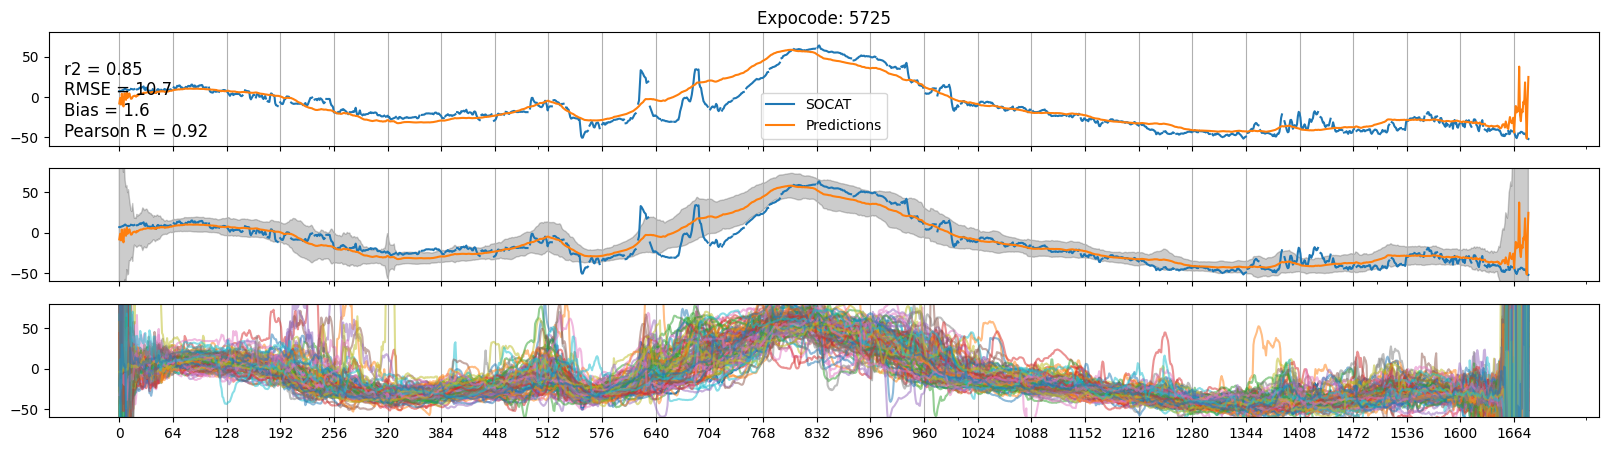

: 

In [ ]:
import matplotlib.pyplot as plt
cruise.set_index(['window_id'], inplace=True)
fig, axs = plt.subplots(3, 1, figsize=(20, 5), sharex=True, sharey=True)
plot_line_comparison(axs[0], cruise['fco2rec_uatm'], cruise['mean_pred'], label='Predictions')
axs[0].set_title(f"Expocode: {expocode}")
axs[0].grid(True, axis='x')
axs[0].set_ylim(-60, 80)
plot_diff_samples(axs[1],cruise[pred_columns], cruise['fco2rec_uatm'], label='Predictions')
axs[1].grid(True, axis='x')
plot_all_samples(axs[2], cruise[pred_columns], cruise['fco2rec_uatm'], label='Predictions')
axs[2].grid(True, axis='x')
cruise.reset_index(inplace=True)